<h1> Kωνσταντίνος Κωνσταντόπουλος - 1η Εργασία Μηχανικής Μάθησης</h1>

<h1> AM: p3170086</h1>

<h2> Exploration and data extraction from FEC data </h2>

<h3> Initialization </h3>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import matplotlib

from collections import defaultdict

%matplotlib inline

matplotlib.style.use('ggplot')

pd.set_option("display.max_columns", None)


<h3> 1)Identify the top 5 Political Action Committees (PACs), or rather, super-PACs, that supported each of the two
presidential candidates, giving the amount of money raised and spent by each one of them. </h3>

<h3> Read Headers for the CSVs we are going to be using, which are:  </h3>

* The committees master file

In [2]:
commitees_header=pd.read_csv("https://www.fec.gov/files/bulk-downloads/data_dictionaries/cm_header_file.csv").columns.tolist()

commitees= pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/cm16.zip', sep="|", index_col=False, names=commitees_header)

* The PAC summary file. Column titles are not given by FEC so I had to write them myself.

In [3]:
pac_summary_header = ['CMTE_ID','CMTE_NM','CMTE_TP','CMTE_DSGN','CMTE_FILING_FREQ','TTL_RECEIPTS','TRANS_FROM_AFF','INDV_CONTRIB','OTHER_POL_CMTE_CONTRIB','CAND_CONTRIB','CAND_LOANS','TTL_LOANS_RECEIVED','TTL_DISB','TRANF_TO_AFF',
        'INDV_REFUNDS','OTHER_POL_CMTE_REFUNDS','CAND_LOAN_REPAY','LOAN_REPAY','COH_BOP','COH_COP','DEBTS_OWED_BY','NONFED_TRANS_RECEIVED','CONTRIB_TO_OTHER_CMTE','IND_EXP','PTY_COORD_EXP','NONFED_SHARE_EXP','CVG_END_DT']

data_types = { header: np.str for header in pac_summary_header }
data_types['TTL_RECEIPTS'] = np.float

pac_summary = pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/webk16.zip', 
                  sep="|", 
                  index_col=False, 
                  names=pac_summary_header, 
                  dtype=data_types)

* The Contributions from committees to candidates file

In [4]:
contrib_h= pd.read_csv("https://www.fec.gov/files/bulk-downloads/data_dictionaries/pas2_header_file.csv").columns.tolist()

data_typ = { header: np.str for header in contrib_h }
data_typ['TRANSACTION_AMT'] = np.float

contrib = pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/pas216.zip', sep="|", index_col=False,dtype=data_typ, names=contrib_h)

* We know that **Hillary Clinton's** candidate ID is **P00003392** and that **Donald Trump's** candidate ID is **P80001571**, so we filter out all contributions not concerning those 2 CAND_IDs

In [5]:
contrib=contrib[contrib['CAND_ID'].isin(['P00003392','P80001571'])]

* Merging the contributions file with committees master to access the name and type of each contribution's committee 

In [6]:
contrib=pd.merge(contrib, 
               commitees[['CMTE_ID','CMTE_TP' ,'CMTE_NM']], 
               on='CMTE_ID', 
               how='inner')

* We now filter out all transactions with a negative value an keep all committees of types N,O,Q. Types N and Q are PACs, whilst type O are Super-PACs. Conclusion drawn from https://www.fec.gov/campaign-finance-data/committee-type-code-descriptions/

In [7]:
contrib=contrib[contrib['TRANSACTION_AMT']>0]

contrib=contrib[contrib['CMTE_TP'].isin(['N','Q','O'])]

* By studying the documentation on the [transaction types](https://www.fec.gov/campaign-finance-data/transaction-type-code-descriptions/) , we can assume that all transaction types of 24E is money given for the benefit of a candidate, whereas type 24A is money given against a candidate. Thus we conclude, that transactions of type 24E for a named candidate and type 24A for the opposing candidate, both work for the benefit of named candidate. We split up in to 4 dataframes for each category.

In [8]:
contrib_copy = contrib.copy()
contrib_copy.groupby(['CMTE_ID'])
print(contrib_copy.shape)

trump_for=contrib_copy.loc[(contrib_copy['CAND_ID']=="P80001571") & (contrib_copy['TRANSACTION_TP'].isin(["24E"]))].groupby(['CMTE_ID'])['TRANSACTION_AMT'].sum().reset_index()
trump_for = trump_for.rename(columns={'TRANSACTION_AMT': 'FOR_TRUMP'})

trump_against=contrib_copy.loc[(contrib_copy['CAND_ID']=="P80001571") & (contrib_copy['TRANSACTION_TP']=="24A")].groupby(['CMTE_ID'])['TRANSACTION_AMT'].sum().reset_index()
trump_against = trump_against.rename(columns={'TRANSACTION_AMT': 'AGAINST_TRUMP'})

hillary_for = contrib_copy.loc[(contrib_copy['CAND_ID']=="P00003392") & (contrib_copy['TRANSACTION_TP'].isin(["24E"]))].groupby(['CMTE_ID'])['TRANSACTION_AMT'].sum().reset_index()
hillary_for = hillary_for.rename(columns={'TRANSACTION_AMT': 'FOR_HILLARY'})

hillary_against = contrib_copy.loc[(contrib_copy['CAND_ID']=="P00003392") & (contrib_copy['TRANSACTION_TP']=="24A")].groupby(['CMTE_ID'])['TRANSACTION_AMT'].sum().reset_index()
hillary_against = hillary_against.rename(columns={'TRANSACTION_AMT': 'AGAINST_HILLARY'})

(11850, 24)


* By merging our 4 dataframes, the result will be a dataframe which each row contains a unique committee id and 4 columns, each containing information based on how money was spent for each candidate.

In [9]:
total=pd.merge(trump_for, 
               trump_against, 
               on='CMTE_ID', 
               how='outer')
total=pd.merge(total, 
               hillary_for, 
               on='CMTE_ID', 
               how='outer')
total=pd.merge(total, 
               hillary_against, 
               on='CMTE_ID', 
               how='outer')
total.fillna(0, inplace=True)

* By carefully examining the committees we can see that some may only give money against each opposing candidate. We chose to excluse these committees since they only work against a candidate but do not support anyone.

In [10]:
noones = total[(total['FOR_HILLARY']<total['AGAINST_HILLARY'])&(total['FOR_TRUMP']<total['AGAINST_TRUMP'])]
noones

,CMTE_ID,FOR_TRUMP,AGAINST_TRUMP,FOR_HILLARY,AGAINST_HILLARY
17,C00487470,29.0,7054203.0,0.0,512.0
94,C00569517,0.0,12000.0,0.0,14409.0
96,C00575373,0.0,93090.0,0.0,4376616.0
100,C00587022,0.0,59007.0,0.0,100.0


* We now devide our dataframe into 2 dataframes that each contain committees that are on each of the candidate's side. 

In [12]:
hillary = total[(total['FOR_HILLARY']+total['AGAINST_TRUMP'])>(total['FOR_TRUMP']+total['AGAINST_HILLARY'])]

trump = total[(total['FOR_HILLARY']+total['AGAINST_TRUMP'])<=(total['FOR_TRUMP']+total['AGAINST_HILLARY'])]

* With the help of lambdas we create 2 new columns on each row, that contain information about how muh money is spent for each presidential candidate.

In [13]:
fn = lambda row: row.FOR_HILLARY + row.AGAINST_TRUMP
col = hillary.apply(fn, axis=1) 
hillary = hillary.assign(TOTAL_HILLARY=col.values) 

fn = lambda row:  row.FOR_TRUMP + row.AGAINST_HILLARY
col = trump.apply(fn, axis=1)
trump = trump.assign(TOTAL_TRUMP=col.values)

* We merge with the PAC summary to access information on how much money each PAC has gathered **We do not have enough information to decide who each individual contribution supports, so we assume that each contribution goes to the candidate that we believe each PAC supports.**

In [14]:
trump=pd.merge(trump, 
               pac_summary[['CMTE_ID','CMTE_NM','TTL_RECEIPTS','INDV_CONTRIB']], 
               on='CMTE_ID', 
               how='inner')

hillary=pd.merge(hillary, 
               pac_summary[['CMTE_ID','CMTE_NM','TTL_RECEIPTS','INDV_CONTRIB']], 
               on='CMTE_ID', 
               how='inner')

trump['TOTAL_TRUMP'] = pd.to_numeric(trump['TOTAL_TRUMP'],errors='coerce')
trump['INDV_CONTRIB'] = pd.to_numeric(trump['INDV_CONTRIB'],errors='coerce')
trump['TTL_RECEIPTS'] = pd.to_numeric(trump['TTL_RECEIPTS'],errors='coerce')
hillary['TTL_RECEIPTS'] = pd.to_numeric(hillary['TTL_RECEIPTS'],errors='coerce')
hillary['TOTAL_HILLARY'] = pd.to_numeric(hillary['TOTAL_HILLARY'],errors='coerce')
hillary['INDV_CONTRIB'] = pd.to_numeric(hillary['INDV_CONTRIB'],errors='coerce')

* Another piece of information that may prove to be useful in our "investigation", is the percentage of total contributions that was actually distributed for use towards our assigned candidate. This information is stored in new column PERCENTAGE_INDIV.

In [15]:
trump['PERCENTAGE_INDIV']=trump['TOTAL_TRUMP']/trump['TTL_RECEIPTS']

hillary['PERCENTAGE_INDIV']=hillary['TOTAL_HILLARY']/hillary['TTL_RECEIPTS']

In [16]:
trump['PERCENTAGE_INDIV'] = pd.to_numeric(trump['PERCENTAGE_INDIV'],errors='coerce')

hillary['PERCENTAGE_INDIV'] = pd.to_numeric(hillary['PERCENTAGE_INDIV'],errors='coerce')

* Here we sort our PACs based on how much money they spent and raised.

In [17]:

trump_top5_spenders=trump.sort_values(by='TOTAL_TRUMP', ascending=False)[:5]
trump_top5_gainers = trump.sort_values(by='TTL_RECEIPTS', ascending=False)[:5]

hillary_top5_spenders=hillary.sort_values(by='TOTAL_HILLARY', ascending=False)[:5]
hillary_top5_gainers = hillary.sort_values(by='TTL_RECEIPTS', ascending=False)[:5]

* It is interesting to see that only a couple of Donald Trump's PAC have spent the largest amount of money towards him or against Hillary. We haven't analyzed the rest of the data but we can make the assumption that the rest of the money was spent on other candidates of the Republican party or against the Democrats.

In [18]:
trump_top5_spenders

,CMTE_ID,FOR_TRUMP,AGAINST_TRUMP,FOR_HILLARY,AGAINST_HILLARY,TOTAL_TRUMP,CMTE_NM,TTL_RECEIPTS,INDV_CONTRIB,PERCENTAGE_INDIV
23,C00574533,23431.0,0.0,0.0,24195670.0,24219101.0,FUTURE45,24996520.04,24955520.04,0.968899
36,C00618876,4095640.0,0.0,81000.0,17103458.0,21199098.0,REBUILDING AMERICA NOW,23616516.94,23472474.94,0.897639
0,C00053553,1867401.0,0.0,265.0,7448175.0,9315576.0,NATIONAL RIFLE ASSOCIATION OF AMERICA POLITICA...,21591111.40,21252709.45,0.431454
65,C00490730,0.0,0.0,0.0,5728857.0,5728857.0,RGA RIGHT DIRECTION PAC,22781720.74,0.00,0.251467
53,C00575373,0.0,93090.0,0.0,4376616.0,4376616.0,MAKE AMERICA NUMBER 1,20737584.81,6389820.31,0.211048


* The FREEDOM PARTNERS ACTION FUND, INC may have only spent 36.000 \\$ against H. Clinton but according to [open secrets](https://www.opensecrets.org/outsidespending/recips.php?cmte=C00564765&cycle=2016) , it spent  \\$ 30 million against Democrats in 2016.

In [19]:
trump_top5_gainers

,CMTE_ID,FOR_TRUMP,AGAINST_TRUMP,FOR_HILLARY,AGAINST_HILLARY,TOTAL_TRUMP,CMTE_NM,TTL_RECEIPTS,INDV_CONTRIB,PERCENTAGE_INDIV
77,C00564765,0.0,0.0,0.0,36329.0,36329.0,"FREEDOM PARTNERS ACTION FUND, INC.",28201407.05,26563016.84,0.001288
23,C00574533,23431.0,0.0,0.0,24195670.0,24219101.0,FUTURE45,24996520.04,24955520.04,0.968899
36,C00618876,4095640.0,0.0,81000.0,17103458.0,21199098.0,REBUILDING AMERICA NOW,23616516.94,23472474.94,0.897639
65,C00490730,0.0,0.0,0.0,5728857.0,5728857.0,RGA RIGHT DIRECTION PAC,22781720.74,0.00,0.251467
0,C00053553,1867401.0,0.0,265.0,7448175.0,9315576.0,NATIONAL RIFLE ASSOCIATION OF AMERICA POLITICA...,21591111.40,21252709.45,0.431454


* We can make the same assumption about Hillary Clinton's PACs, but we can notice that the amount of contributions that PACs have gathered and/or spent are much larger of them at D. Trumps side. With the **PRIORITIES USA ACTION PAC** being the star of the show having raised whopping **\\$192 million** and spent **\\$132 million** for Hillary Clinton, of which **\\$126 million** is spent against D. Trump

In [20]:
hillary_top5_spenders

,CMTE_ID,FOR_TRUMP,AGAINST_TRUMP,FOR_HILLARY,AGAINST_HILLARY,TOTAL_HILLARY,CMTE_NM,TTL_RECEIPTS,INDV_CONTRIB,PERCENTAGE_INDIV
25,C00495861,0.0,126062193.0,6473727.0,0.0,132535920.0,PRIORITIES USA ACTION,1.920658e+08,1.567163e+08,0.690055
50,C00603621,0.0,16353117.0,0.0,0.0,16353117.0,OUR PRINCIPLES PAC,1.902490e+07,1.866296e+07,0.859564
30,C00523621,0.0,8674114.0,4825838.0,4392.0,13499952.0,UNITED WE CAN,2.420699e+07,1.599422e+07,0.557688
56,C00615815,0.0,13240861.0,0.0,0.0,13240861.0,NEXTGEN CALIFORNIA ACTION COMMITTEE,1.323263e+07,0.000000e+00,1.000622
17,C00473918,0.0,5975968.0,5651780.0,0.0,11627748.0,WOMEN VOTE!,3.668587e+07,1.481483e+07,0.316954


In [21]:
hillary_top5_gainers

,CMTE_ID,FOR_TRUMP,AGAINST_TRUMP,FOR_HILLARY,AGAINST_HILLARY,TOTAL_HILLARY,CMTE_NM,TTL_RECEIPTS,INDV_CONTRIB,PERCENTAGE_INDIV
25,C00495861,0.0,126062193.0,6473727.0,0.0,132535920.0,PRIORITIES USA ACTION,1.920658e+08,1.567163e+08,0.690055
42,C00571372,0.0,25162.0,0.0,0.0,25162.0,RIGHT TO RISE USA,1.216952e+08,1.183599e+08,0.000207
36,C00547349,0.0,4675455.0,2420617.0,0.0,7096072.0,NEXTGEN CLIMATE ACTION COMMITTEE,9.301024e+07,9.110163e+07,0.076293
19,C00484642,0.0,1823372.0,228496.0,0.0,2051868.0,SENATE MAJORITY PAC,9.282108e+07,6.771575e+07,0.022106
35,C00541292,0.0,6080765.0,0.0,0.0,6080765.0,CONSERVATIVE SOLUTIONS PAC,6.056422e+07,6.023422e+07,0.100402


<h3> 2) Identify the top 10 individual donors (i.e., persons) for each of the two presidential candidates and the
amount they spent. In order to do that, you should know that donations are not always to a fundraising
committee that can be directly linked to a candidate, but they can be due to other entities such as PACs.
 </h3>

* We read the header and CSV of the the Contributions by Individuals file

In [22]:
individuals_header=pd.read_csv("contributions_by_individuals/indiv_header_file.csv").columns.tolist()

data_types_com = { headers: np.str for headers in individuals_header }
data_types_com['TRANSACTION_AMT'] = np.float

contributions = pd.read_csv('contributions_by_individuals/itcont.txt', sep="|", index_col=False, names=individuals_header,dtype=data_types_com,parse_dates=['TRANSACTION_DT'])

* A copy is made everytime we need to re-run the cells instead of reading the CSV from the beginning (takes much longer).

In [23]:
contribution_by_indiv=contributions.copy()


* After our initial sort of individual contributors we can notice some names popping up with slight differences, so we map them out. Another this we can notice is that a PAC shows up (maybe false data?) in put contributors list, so the necessary changes are made.

In [24]:
contribution_by_indiv=contribution_by_indiv.loc[contribution_by_indiv['ENTITY_TP'].isin(['IND'])]
contribution_by_indiv.loc[contribution_by_indiv['NAME'] == 'ASSOCIATION, NATIONAL EDUCATION', ['ENTITY_TP']] = 'PAC'

emp_mapping = {
    'SIMONS, JAMES H.' : 'SIMONS, JAMES',
    'SUSSMAN, S. DONALD' : 'SUSSMAN, DONALD',
    'HENDRICKS, DIANE MS.' : 'HENDRICKS, DIANE'
}

f = lambda x: emp_mapping.get(x, x) 
contribution_by_indiv.loc[:, 'NAME'] = contribution_by_indiv.loc[:, 'NAME'].map(f)

* We use the dataframes from the previous question to access the ids of PACs spread out to each candidate.

In [25]:
trump_ids=trump['CMTE_ID'].tolist()
hillary_ids=hillary['CMTE_ID'].tolist()

* Distribution of PACs in to the correct Dataframes and then grouping by name and sorting by the amount of money given (TRANSACTION_AMT).

In [26]:
contrib_hillary=contribution_by_indiv[contribution_by_indiv['CMTE_ID'].isin(hillary_ids)]
contrib_trump=contribution_by_indiv[contribution_by_indiv['CMTE_ID'].isin(trump_ids)]

contrib_hillary=contrib_hillary.groupby(['NAME']).sum().sort_values(by='TRANSACTION_AMT', ascending=False)
contrib_trump=contrib_trump.groupby(['NAME']).sum().sort_values(by='TRANSACTION_AMT', ascending=False)

* If we were to compare the amount of money donated by individuals it is made clear that Hillary Clinton had the support of some very wealthy people (The sum of D. Trumps top 10 contributor's money is less than the amount that Mr. Thomas Steyer donated to Hillary Clinton).

In [27]:
contrib_hillary.head(10)

,TRANSACTION_AMT
NAME,
"STEYER, THOMAS F.",89500000.0
"SUSSMAN, DONALD",37000000.0
"EYCHANER, FRED",35250000.0
"SIMONS, JAMES",22000680.0
"BLOOMBERG, MICHAEL R.",21665124.0
"SOROS, GEORGE",19699693.0
"MOSKOVITZ, DUSTIN",13625000.0
"PRITZKER, JAY ROBERT",9650848.0
"ABRAHAM, DANIEL",9250000.0


* The data shown in this classification is not completely true since the names in our dataset are not consistent. Only with the correct mapping of all names would we be able to draw conclusions. 

In [28]:
contrib_trump.head(10)

,TRANSACTION_AMT
NAME,
"MERCER, ROBERT",15500000.0
"HENDRICKS, DIANE",12152900.0
"ADELSON, MIRIAM",10000000.0
"ADELSON, SHELDON",10000000.0
"MCMAHON, LINDA E.",7000000.0
"MARCUS, BERNARD",7000000.0
"UIHLEIN, RICHARD E.",5240000.0
"PALMER, GEOFFREY H.",4000000.0
"BEAL, DANIEL A.",3615764.0


<h3> 3) Investigate the chronological evolution of the contributions made to and the expenditures made by the
campaigns
 </h3>

* We read the header and CSV of the Operating Expenditures file

In [29]:
expenses_header=pd.read_csv("https://www.fec.gov/files/bulk-downloads/data_dictionaries/oppexp_header_file.csv").columns.tolist()
data_types_com = { headers: np.str for headers in expenses_header }
data_types_com['TRANSACTION_AMT'] = np.float

expenses = pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/oppexp16.zip', sep="|", index_col=False, names=expenses_header,dtype=data_types_com,parse_dates=['TRANSACTION_DT'])

* We merge with the committees data to gain access on information concerning the name, type and candidate that the committee supports. According to the [documentation](https://www.fec.gov/campaign-finance-data/committee-master-file-description/), the CAND_ID column is not null only when CMTE_TP is equal to 'P', meaning that the committee is clearly a supporter of the presidential candidate.  

In [30]:
import datetime

expenses=pd.merge(expenses, 
               commitees[['CMTE_ID','CMTE_NM','CMTE_TP','CAND_ID']], 
               on='CMTE_ID', 
               how='inner')

* Here we filter out all dates that are not in the 2015-2016 dates and cast the TRANSACTION_DT column from an object to a date.

In [31]:
expenses['TRANSACTION_DT'] = pd.to_datetime(expenses['TRANSACTION_DT'], errors='coerce').dt.date
expenses = expenses[(expenses['TRANSACTION_DT']>datetime.date(2014,12,31))&(expenses['TRANSACTION_DT']<datetime.date(2017,1,1))]
expenses = expenses.set_index(pd.DatetimeIndex(expenses['TRANSACTION_DT']))

* The committees we take into concideration are the ones we know for sure that support a candidate. There are only 2 possibilities, either the committe is presidential (explained above), or it is one of the PACs which we carefully assigned to each candidate earlier.

In [32]:
trump_expenses=expenses[((expenses['CMTE_TP']=='P')&(expenses['CAND_ID']=="P80001571"))|(expenses['CMTE_ID'].isin(trump_ids))]
hillary_expenses=expenses[((expenses['CMTE_TP']=='P')&(expenses['CAND_ID']=="P00003392"))|(expenses['CMTE_ID'].isin(hillary_ids))]

In [33]:
hillary_expenses['TRANSACTION_AMT'].sum()

845932277.1999999

* We group our collected data for each month in the 2015-2016 period.

In [34]:
trump_expenses=trump_expenses.groupby(pd.Grouper(freq='M')).sum().sort_values(by='TRANSACTION_DT', ascending=True).reset_index()
hillary_expenses= hillary_expenses.groupby(pd.Grouper(freq='M')).sum().sort_values(by='TRANSACTION_DT', ascending=True).reset_index()

* It is interesting to see that Hillary Clinton actually spent **twice** the amount of money that Donald Trump spent on his campaign! (possible data missing)

In [35]:
hillary_total_expenses = hillary_expenses['TRANSACTION_AMT'].sum()
hillary_total_expenses

845932277.2000014

In [36]:
trump_total_expenses=trump_expenses['TRANSACTION_AMT'].sum()
trump_total_expenses

418996007.1899994

* Below we see how the data is destributed by month.

In [37]:
trump_expenses

,TRANSACTION_DT,TRANSACTION_AMT
0,2015-01-31,1.226227e+06
1,2015-02-28,1.552177e+06
2,2015-03-31,1.961462e+06
3,2015-04-30,2.290474e+06
4,2015-05-31,2.222634e+06
5,2015-06-30,2.846405e+06
6,2015-07-31,3.230750e+06
7,2015-08-31,3.754978e+06
8,2015-09-30,3.896815e+06
9,2015-10-31,3.691653e+06


In [38]:
hillary_expenses

,TRANSACTION_DT,TRANSACTION_AMT
0,2015-01-31,2.467923e+06
1,2015-02-28,2.658381e+06
2,2015-03-31,4.210487e+06
3,2015-04-30,7.232264e+06
4,2015-05-31,1.234020e+07
5,2015-06-30,1.394988e+07
6,2015-07-31,2.055562e+07
7,2015-08-31,1.455028e+07
8,2015-09-30,1.591543e+07
9,2015-10-31,2.155387e+07


* We merge with the committees data to gain access on information concerning the name, type and candidate that the committee supports. According to the [documentation](https://www.fec.gov/campaign-finance-data/committee-master-file-description/), the CAND_ID column is not null only when CMTE_TP is equal to 'P', meaning that the committee is clearly a supporter of the presidential candidate.  

In [39]:
print(contributions.shape)

contributions=pd.merge(contributions, 
               commitees[['CMTE_ID','CMTE_NM','CMTE_TP','CAND_ID']], 
               on='CMTE_ID', 
               how='inner')

(20468532, 21)


* Necessary actions are taken to convert TRANSACTION_DT into readable dates and filter out data that doesn't belong to the 2015-2016 period.

In [40]:
contributions['TRANSACTION_DT'] = pd.to_datetime(contributions['TRANSACTION_DT'], format='%d%m%Y', errors='coerce')
print(contributions.dtypes)

contributions = contributions[(contributions['TRANSACTION_DT'].dt.date >= datetime.date(year=2015,month=1,day=1))& (contributions['TRANSACTION_DT'].dt.date < datetime.date(year=2017,month=1,day=1))]
contributions = contributions.set_index(pd.DatetimeIndex(contributions['TRANSACTION_DT']))
print(contributions.shape)


CMTE_ID                    object
AMNDT_IND                  object
RPT_TP                     object
TRANSACTION_PGI            object
IMAGE_NUM                  object
TRANSACTION_TP             object
ENTITY_TP                  object
NAME                       object
CITY                       object
STATE                      object
ZIP_CODE                   object
EMPLOYER                   object
OCCUPATION                 object
TRANSACTION_DT     datetime64[ns]
TRANSACTION_AMT           float64
OTHER_ID                   object
TRAN_ID                    object
FILE_NUM                   object
MEMO_CD                    object
MEMO_TEXT                  object
SUB_ID                     object
CMTE_NM                    object
CMTE_TP                    object
CAND_ID                    object
dtype: object
(6585682, 24)


In [41]:
contrib_hillary=contributions[((contributions['CMTE_TP']=='P')&(contributions['CAND_ID']=="P00003392"))|(contributions['CMTE_ID'].isin(hillary_ids))]
contrib_hillary= contrib_hillary.groupby(pd.Grouper(freq='M')).sum().sort_values(by='TRANSACTION_DT', ascending=True).reset_index()

contrib_trump=contributions[((contributions['CMTE_TP']=='P')&(contributions['CAND_ID']=="P80001571"))|(contributions['CMTE_ID'].isin(trump_ids))]
contrib_trump= contrib_trump.groupby(pd.Grouper(freq='M')).sum().sort_values(by='TRANSACTION_DT', ascending=True).reset_index()

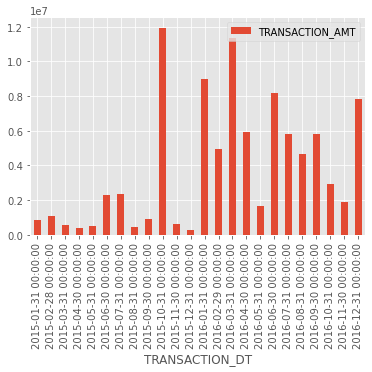

In [42]:
contrib_trump.plot(x ='TRANSACTION_DT', y='TRANSACTION_AMT', kind = 'bar')

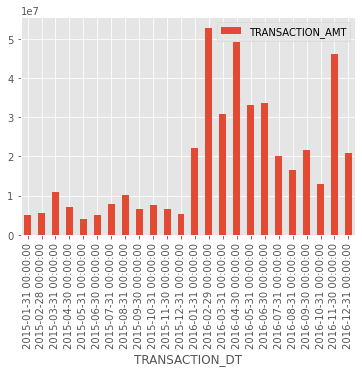

In [43]:
contrib_hillary.plot(x ='TRANSACTION_DT', y='TRANSACTION_AMT', kind = 'bar')

* By carefully examining the plots below, we can see that expenses for both candidates sky rockets during the election period (September, October, November) .

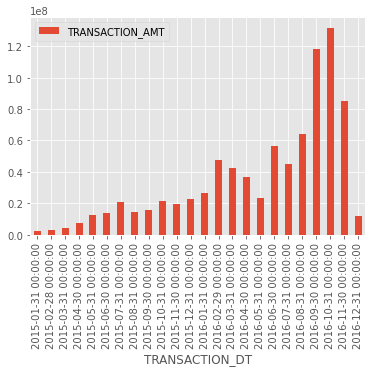

In [44]:
hillary_expenses.plot(x ='TRANSACTION_DT', y='TRANSACTION_AMT', kind = 'bar')

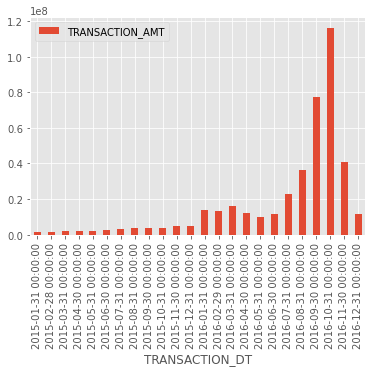

In [45]:
trump_expenses.plot(x ='TRANSACTION_DT', y='TRANSACTION_AMT', kind = 'bar')

<h3> 4) Identify the biggest recipients of campaign expenditures. </h3>

* All we have to do is filter out the correct committees, examine all expenses made from them and then group by name of the company that received the money.

In [46]:
trump_expenses=expenses[((expenses['CMTE_TP']=='P')&(expenses['CAND_ID']=="P80001571"))|(expenses['CMTE_ID'].isin(trump_ids))]
hillary_expenses=expenses[((expenses['CMTE_TP']=='P')&(expenses['CAND_ID']=="P00003392"))|(expenses['CMTE_ID'].isin(hillary_ids))]

trump_comps = trump_expenses.groupby(['NAME'])['TRANSACTION_AMT'].sum().sort_values(ascending=False).reset_index()
hillary_comps = hillary_expenses.groupby(['NAME'])['TRANSACTION_AMT'].sum().sort_values(ascending=False).reset_index()

In [47]:
trump_comps.head(20)

,NAME,TRANSACTION_AMT
0,GILES-PARSCALE,87838378.10
1,AMERICAN MEDIA & ADVOCACY GROUP,74176379.30
2,"RICK REED MEDIA, INC.",24460099.45
3,AMERICAN EXPRESS,19427054.67
4,"ACE SPECIALTIES, LLC",15885323.63
5,"PRIVATE JET SERVICES, LLC",9953216.06
6,JAMESTOWN ASSOCIATES,8836595.01
7,"TAG AIR, INC.",8741464.25
8,AIR CHARTER TEAM,8321403.26
9,"CAMBRIDGE ANALYTICA, LLC",5912500.00


In [48]:
hillary_comps.head(20)

,NAME,TRANSACTION_AMT
0,GMMB,3.084634e+08
1,BULLY PULPIT INTERACTIVE LLC,4.013508e+07
2,ADP,2.909583e+07
3,AMERICAN EXPRESS,2.720724e+07
4,MARKHAM PRODUCTIONS,1.602585e+07
5,EXECUTIVE FLITEWAYS,1.586629e+07
6,PAYROLL DATA PROCESSING,1.124838e+07
7,"AIR PARTNERS, INC.",1.115633e+07
8,STRIPE,1.033458e+07
9,SEIU GENERAL FUND,7.886324e+06


<h3> 5) Examine the geographical distribution, at the state level, of campaign expenditures. For each state,
calculate the expenditures per voter. This will require that you find a source with the number of registered
voters per state. Examine the situation for swing states.
 </h3>

* Government data that contains eligibility of voters per state.

In [49]:
registered = pd.read_csv('https://www.eac.gov/sites/default/files/Research/EAVS_2016_Final_Data_for_Public_Release_v2.csv.zip', usecols=["State", "A1a"],low_memory=False)

* Searched for datasets on the internet that contain the party that won per state to analyze their expenses and to determine if the amount of money they spend actually gives them a state win.

In [50]:
full = pd.read_csv('https://query.data.world/s/5li6jmqclpzydielgcwynkkvup5zqo') #this data is mising for some reason the state of Louisiana
states = pd.read_csv('https://query.data.world/s/lx674mcokakfgsyof5z6tk62tmrio6')
full=pd.merge(full, 
               states, 
               on='State',
               how="inner")

* Clear up our data, Puerto Rico is not a US state. We group by states since al cities are in the data and sum their population.

In [51]:
registered['A1a'] =pd.to_numeric(registered['A1a'], errors='coerce')
registered = registered.rename(columns={'State': 'STATE'})
registered= registered[~registered['STATE'].isin(['PR'])]
registered = registered.groupby(['STATE']).sum().sort_values(by='A1a')


* Merge all our data so we now have all needed information gathered in one dataframe. A correction is made in the data since North Dakota's population is all registered to vote.

In [52]:
registered=pd.merge(registered, full, how='inner', left_on='STATE', right_on='Abbreviation')
registered.loc[registered['Abbreviation'] == 'ND', ['A1a']] = 754.434 #In North Dakota everyone is registered to vote, in the data it's A1a is 0.

* Filtering out all correct expenses based on assigned committees and grouping them by state.

In [53]:
trump_expenses=expenses[((expenses['CMTE_TP']=='P')&(expenses['CAND_ID']=="P80001571"))|(expenses['CMTE_ID'].isin(trump_ids))]
hillary_expenses=expenses[((expenses['CMTE_TP']=='P')&(expenses['CAND_ID']=="P00003392"))|(expenses['CMTE_ID'].isin(hillary_ids))]


trump_expenses = trump_expenses.groupby(['STATE'])['TRANSACTION_AMT'].sum().reset_index()
hillary_expenses = hillary_expenses.groupby(['STATE'])['TRANSACTION_AMT'].sum().reset_index()

* Finally, we merge all our data based on the Abbreviation of each state

In [54]:
trump_expenses=pd.merge(trump_expenses, registered, how='inner', left_on='STATE', right_on='Abbreviation')

hillary_expenses=pd.merge(hillary_expenses, registered, how='inner', left_on='STATE', right_on='Abbreviation')

* For each of the 2 candidates we now divide all expenses by the population in each state to get the amount of \\$/person .

* We can notice a huge spike in USA's capital's state, DC, where most are the PACs are stationed.

In [55]:
trump_expenses['TOTAL_TRUMP']=trump_expenses['TRANSACTION_AMT']/trump_expenses['A1a']

trump_expenses

,STATE,TRANSACTION_AMT,A1a,State,Votes,Winning Party,Abbreviation,TOTAL_TRUMP
0,AK,2.024487e+04,5.873030e+05,Alaska,3,Republicans,AK,0.034471
1,AL,8.937236e+05,3.333946e+06,Alabama,9,Republicans,AL,0.268068
2,AR,2.623814e+05,1.765513e+06,Arkansas,6,Republicans,AR,0.148615
3,AZ,6.319766e+06,4.080680e+06,Arizona,11,Republicans,AZ,1.548704
4,CA,1.142289e+07,2.448664e+07,California,55,Democrats,CA,0.466495
5,CO,3.057243e+06,3.840303e+06,Colorado,9,Democrats,CO,0.796094
6,CT,1.666276e+06,2.331684e+06,Connecticut,7,Democrats,CT,0.714623
7,DC,1.571156e+07,4.932870e+05,District of Columbia,3,Democrats,DC,31.850756
8,DE,3.393263e+06,6.756630e+05,Delaware,3,Democrats,DE,5.022124
9,FL,1.639515e+07,1.350557e+07,Florida,29,Republicans,FL,1.213955


In [56]:
hillary_expenses['TOTAL_HILLARY']=hillary_expenses['TRANSACTION_AMT']/hillary_expenses['A1a']

hillary_expenses

,STATE,TRANSACTION_AMT,A1a,State,Votes,Winning Party,Abbreviation,TOTAL_HILLARY
0,AK,3.555430e+04,5.873030e+05,Alaska,3,Republicans,AK,0.060538
1,AL,3.159969e+06,3.333946e+06,Alabama,9,Republicans,AL,0.947817
2,AR,1.682843e+07,1.765513e+06,Arkansas,6,Republicans,AR,9.531748
3,AZ,6.610760e+05,4.080680e+06,Arizona,11,Republicans,AZ,0.162001
4,CA,3.704482e+07,2.448664e+07,California,55,Democrats,CA,1.512858
5,CO,1.195911e+07,3.840303e+06,Colorado,9,Democrats,CO,3.114107
6,CT,1.201941e+07,2.331684e+06,Connecticut,7,Democrats,CT,5.154819
7,DC,4.449680e+08,4.932870e+05,District of Columbia,3,Democrats,DC,902.046974
8,DE,1.744907e+06,6.756630e+05,Delaware,3,Democrats,DE,2.582510
9,FL,2.807361e+07,1.350557e+07,Florida,29,Republicans,FL,2.078669


* To narrow down our investigation we look closely at [2016's swing states](https://en.wikipedia.org/wiki/Swing_state#Determining_swing_states)

In [57]:
swing_states=['ME', 'NC','MN','NH','MI','GA','WI','FL','AZ','NV','PA']
hillary_expenses.loc[hillary_expenses['STATE'].isin(swing_states)].sort_values(by='Winning Party')

,STATE,TRANSACTION_AMT,A1a,State,Votes,Winning Party,Abbreviation,TOTAL_HILLARY
20,ME,131073.03,1065100.0,Maine,3,Democrats,ME,0.123062
23,MN,1482725.63,3473972.0,Minnesota,10,Democrats,MN,0.426810
30,NH,3966222.50,988398.0,New Hampshire,4,Democrats,NH,4.012779
33,NV,2895260.98,1678883.0,Nevada,6,Democrats,NV,1.724516
3,AZ,661076.04,4080680.0,Arizona,11,Republicans,AZ,0.162001
9,FL,28073614.09,13505571.0,Florida,29,Republicans,FL,2.078669
10,GA,3313178.46,6657621.0,Georgia,16,Republicans,GA,0.497652
21,ME,131073.03,1065100.0,Maine,1,Republicans,ME,0.123062
22,MI,1262811.90,7514055.0,Michigan,16,Republicans,MI,0.168060
27,NC,1338696.70,6924469.0,North Carolina,15,Republicans,NC,0.193328


In [58]:
trump_expenses.loc[trump_expenses['STATE'].isin(swing_states)].sort_values(by='Winning Party',ascending=False)

,STATE,TRANSACTION_AMT,A1a,State,Votes,Winning Party,Abbreviation,TOTAL_TRUMP
3,AZ,6319765.74,4080680.0,Arizona,11,Republicans,AZ,1.548704
9,FL,16395149.35,13505571.0,Florida,29,Republicans,FL,1.213955
10,GA,4258013.71,6657621.0,Georgia,16,Republicans,GA,0.639570
21,ME,117382.21,1065100.0,Maine,1,Republicans,ME,0.110208
22,MI,929822.64,7514055.0,Michigan,16,Republicans,MI,0.123744
27,NC,2483726.78,6924469.0,North Carolina,15,Republicans,NC,0.358688
38,PA,2338879.22,8722975.0,Pennsylvania,20,Republicans,PA,0.268129
48,WI,1039734.58,3768373.0,Wisconsin,10,Republicans,WI,0.275911
20,ME,117382.21,1065100.0,Maine,3,Democrats,ME,0.110208
23,MN,482897.77,3473972.0,Minnesota,10,Democrats,MN,0.139005


* We create a dataframe that contains both candidate's \\$/person to see if the amount of money spent actually gives you a win.

In [59]:
total_states = pd.merge(trump_expenses,hillary_expenses[['Abbreviation','TOTAL_HILLARY']],how='inner',on='Abbreviation')
total_states=total_states.loc[total_states['Abbreviation'].isin(swing_states)].sort_values(by='Winning Party')
total_states

,STATE,TRANSACTION_AMT,A1a,State,Votes,Winning Party,Abbreviation,TOTAL_TRUMP,TOTAL_HILLARY
20,ME,117382.21,1065100.0,Maine,3,Democrats,ME,0.110208,0.123062
21,ME,117382.21,1065100.0,Maine,3,Democrats,ME,0.110208,0.123062
25,MN,482897.77,3473972.0,Minnesota,10,Democrats,MN,0.139005,0.426810
32,NH,11743267.33,988398.0,New Hampshire,4,Democrats,NH,11.881112,4.012779
35,NV,1404658.85,1678883.0,Nevada,6,Democrats,NV,0.836663,1.724516
3,AZ,6319765.74,4080680.0,Arizona,11,Republicans,AZ,1.548704,0.162001
9,FL,16395149.35,13505571.0,Florida,29,Republicans,FL,1.213955,2.078669
10,GA,4258013.71,6657621.0,Georgia,16,Republicans,GA,0.639570,0.497652
22,ME,117382.21,1065100.0,Maine,1,Republicans,ME,0.110208,0.123062
23,ME,117382.21,1065100.0,Maine,1,Republicans,ME,0.110208,0.123062


* We can see that both parties spent a huge amount of money on New Hampshire. Even though Trump's campaign spent 3 times the amount they still managed to lose that state. By looking at 2020's election results we can see that Joe Biden won that state with a 7% difference, not so much of a swing state is it?

* Based on our data one can not make the assumption that spending more money will actually give you the win. Specific examples of such are New Hampshire, Florida, Michigan, Pennsylvania, which happen to be the swing states that give out the most electoral votes.